In [1]:
# Gerekli paketlerin import edilmesi
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# DL için gerekli parametrelerin sağlanması 

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\buzme\Desktop\Project2\Face-Mask-Detection-master\Face-Mask-Detection-master\my_program\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
# Dataların 224x224 olacak şekilde güncellenmesi ve kaydedilmesi

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


C:\Users\buzme\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
# Dataların np array olacak şekilde düzenlenmesi

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [7]:
# Data Augmentation için gerekli kod bölümü
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:
# MobileNetV2'nin tanımı

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 1s 0us/step


In [9]:
# Modelin özeti
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
# Modelin 7x7 ile biten sonunun güncellenip bizim modelimize uygun güncellenmesi

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
# Eklenen modellerin yeni temel model yapılması

model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
# Yeni modelin özeti
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
# İlk training süresince karar vermemesi için aşağıdaki kod öbeği kullanılmaktadır

for layer in baseModel.layers:
	layer.trainable = False

In [15]:
# Modelin compile edilmesi  
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [16]:
# Modelin train edilmesi
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 96s 965ms/step - loss: 0.6442 - accuracy: 0.6994 - val_loss: 0.1549 - val_accuracy: 0.9778
Epoch 2/20
95/95 [==============================] - 103s 1s/step - loss: 0.1692 - accuracy: 0.9608 - val_loss: 0.0803 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 93s 983ms/step - loss: 0.1151 - accuracy: 0.9719 - val_loss: 0.0600 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 95s 1s/step - loss: 0.0865 - accuracy: 0.9790 - val_loss: 0.0487 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 98s 1s/step - loss: 0.0708 - accuracy: 0.9799 - val_loss: 0.0443 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 93s 977ms/step - loss: 0.0725 - accuracy: 0.9782 - val_loss: 0.0378 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 91s 957ms/step - loss: 0.0423 - accuracy: 0.9888 - val_loss: 0.0340 - val_

In [17]:
# Test set ile predict edilmesi
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [18]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [20]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


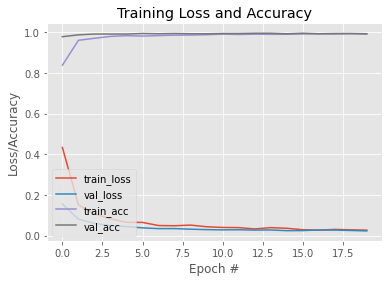

In [21]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")